In [1]:

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import plotly
import shapely.geometry
from shapely.geometry import mapping
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
from scipy import spatial

import requests, io, json
import numpy as np
import itertools
import plotly.express as px
from scipy.spatial import distance


# Function

In [2]:
####### Intersection #########

# Return true if line segments AB and CD intersect
def ccw(A,B,C):
    return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)


### Nearest Point from Point####
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2),np.min(dist_2)

##### IDW ########
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)
    # In IDW, weights are 1 / distance
    weights = 1.0 / dist
    # Make weights sum to one
    weights /= weights.sum(axis=0)
    # Multiply the weights for each interpolated point by all observed Z-values 
    zi = np.dot(weights.T, z)
    return zi


# Read File

In [3]:
# Read an inpu file

icesat = '/home/jovyan/exchange/4_Validation/icesat2_processed_raw.shp'
icesat = gpd.read_file(icesat)

df = pd.DataFrame(icesat)
df.head(2)


,depth,x,y,srf,weak beam,high noise,date,track_key,ATL03 fold,ml_name,geometry
0,-16.192910,243562.075781,2.892521e+06,-32.736122,1,1,20181018,gt1l,20181018T202112,stacked_lstm_model_v1.h5,POINT (243562.0757806193 2892520.860430578)
1,-16.439189,243561.090563,2.892534e+06,-32.735333,1,1,20181018,gt1l,20181018T202112,stacked_lstm_model_v1.h5,POINT (243561.0905625777 2892533.66505603)


# 1) Plot All Lines

A) Point Dataframe and interactive plots

Number of lines: 185


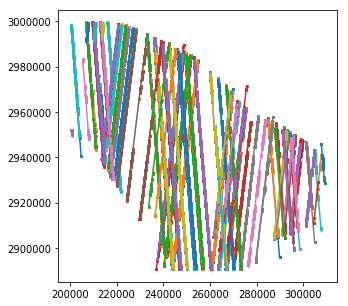

'1_Icesat2.html'

In [4]:

# Create a unique ID
df['ID'] = df['date'].astype(str) + df['track_key']
groups = df.groupby('ID')[['x','y']]
print("Number of lines:",len(groups))

# Plot a standart plot
fig, ax = plt.subplots(figsize=(5,5))
for track, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='-', ms=1.2, label=track)
# ax.legend()
plt.show()

# Plot a interactive plot
fig = px.scatter(df, x='x', y='y', color='ID',hover_name='depth')
fig = px.line(df, x='x', y='y', color='ID', markers=True)
plotly.offline.plot(fig, filename='1_Icesat2.html')


In [5]:

# Tracks to Linestring
geometry = [Point(xy) for xy in zip(df.x, df.y)]
df = GeoDataFrame(df, geometry = geometry)
df['ID'] = df['date'].astype(str) + df['track_key']

# Aggregate these points with the GroupBy
df_group = df.groupby(['ID'])['geometry'].apply(lambda x: LineString(x.tolist()))
gdf_linestring = GeoDataFrame(df_group, geometry = 'geometry')
gdf_linestring.head(2)

# gdf_linestring.plot(column=gdf_linestring.index.values, figsize = (5,10), legend=True)


,geometry
ID,
20181018gt1l,LINESTRING (243562.0757806193 2892520.86043057...
20181018gt1r,LINESTRING (243751.6051469923 2891093.46944651...


In [6]:

# Find max and min X coordinates for each line and append an Y coordinate accordingly
idxmin = df.groupby(by ='ID')['x'].idxmin()
df_min = df.loc[idxmin,]

idxmax = df.groupby(by ='ID')['x'].idxmax()
df_max = df.loc[idxmax,]

df_xy = df_min.merge(df_max, how = 'left', on='ID')
df_xy.head(3)


,depth_x,x_x,y_x,srf_x,weak beam_x,high noise_x,date_x,track_key_x,ATL03 fold_x,ml_name_x,...,x_y,y_y,srf_y,weak beam_y,high noise_y,date_y,track_key_y,ATL03 fold_y,ml_name_y,geometry_y
0,-6.333849,235862.134008,2.991913e+06,-34.648979,1,0,20181018,gt1l,20181018T202814,stacked_lstm_model_v1.h5,...,243562.075781,2.892521e+06,-32.736122,1,1,20181018,gt1l,20181018T202112,stacked_lstm_model_v1.h5,POINT (243562.0757806193 2892520.860430578)
1,-16.015138,235882.131338,2.992675e+06,-34.709790,0,0,20181018,gt1r,20181018T202814,stacked_lstm_model_v1.h5,...,243751.605147,2.891093e+06,-32.932191,0,1,20181018,gt1r,20181018T202112,stacked_lstm_model_v1.h5,POINT (243751.6051469923 2891093.469446518)
2,-1.296220,239208.270920,2.990129e+06,-34.598163,1,0,20181018,gt2l,20181018T202814,stacked_lstm_model_v1.h5,...,246907.926142,2.890777e+06,-32.699842,1,1,20181018,gt2l,20181018T202112,stacked_lstm_model_v1.h5,POINT (246907.9261422285 2890776.571861077)


In [7]:

# create a Linestring GeoDataFrame from max and min coordinates[x,y]
gdf = gpd.GeoDataFrame(
    data = df_xy,
    geometry = df_xy.apply(
        lambda r: shapely.geometry.LineString([(r["x_x"], r["y_x"]),(r["x_y"], r["y_y"]) ]), axis=1)) 

gdf.head(1)



,depth_x,x_x,y_x,srf_x,weak beam_x,high noise_x,date_x,track_key_x,ATL03 fold_x,ml_name_x,...,y_y,srf_y,weak beam_y,high noise_y,date_y,track_key_y,ATL03 fold_y,ml_name_y,geometry_y,geometry
0,-6.333849,235862.134008,2.991913e+06,-34.648979,1,0,20181018,gt1l,20181018T202814,stacked_lstm_model_v1.h5,...,2.892521e+06,-32.736122,1,1,20181018,gt1l,20181018T202112,stacked_lstm_model_v1.h5,POINT (243562.0757806193 2892520.860430578),LINESTRING (235862.1340082197 2991912.57873340...


# 2) Intersection Points of icesat-2 tracks

Total Number of Intersections: 848


'2_Intersections.html'

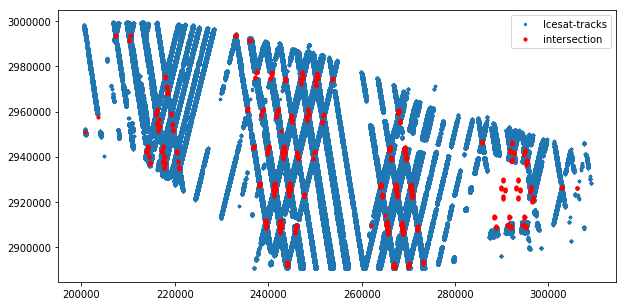

In [8]:

i=0
j=0
df_inter = pd.DataFrame(columns=['L1', 'L2', 'x_int','y_int'])

for index1, row1 in df_xy.iterrows():
    a1= Point(row1.x_x,row1.y_x)
    a2= Point(row1.x_y,row1.y_y)
    i+=1
    for index2, row2 in df_xy[i:].iterrows():
        b1= Point(row2.x_x,row2.y_x)
        b2= Point(row2.x_y,row2.y_y)
        if intersect(a1,a2,b1,b2)==True:
            j+=1
            x_int, y_int = get_intersect(a1,a2,b1,b2)
            df_inter.loc[j] = [row1.ID, row2.ID,x_int, y_int]
                            

print('Total Number of Intersections:',len(df_inter))
df_inter.head(3)

fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(df.x, df.y, label='Icesat-tracks',s=5)
plt.scatter(df_inter.x_int,df_inter.y_int, s=10 ,c='r', label='intersection')
plt.legend()

df_inter['dummy_size'] = .5

fig1 = px.line(df, x='x', y='y', color='ID', markers=True,)
fig1.update_traces(line=dict(color = 'rgba(50,50,50,0.2)'))
fig2 = px.scatter(df_inter, x='x_int', y='y_int', hover_name='L2', color_discrete_sequence = ['red'], size='dummy_size', size_max=10, width=100)

fig3 = go.Figure(data=fig1.data + fig2.data)
plotly.offline.plot(fig3, filename='2_Intersections.html')


# 3) Nearest Points from Intersection Points

In [ ]:

# Create geometries 
geom_list_intersection = [shapely.geometry.Point(lon,lat) for lon,lat in zip(df_inter["x_int"],df_inter["y_int"])] # check the ordering of lon/lat
geom_list_points = [shapely.geometry.Point(lon,lat) for lon,lat in zip(df["x"],df["y"])] # check the ordering of lon/lat

# Create geopandas dataframe
gdf_intersection = gpd.GeoDataFrame(df_inter, geometry=geom_list_intersection, crs = {"init":"EPSG:4326"})
gdf_points = gpd.GeoDataFrame(df, geometry = geom_list_points, crs = {"init":"EPSG:4326"})

print('Number of intersections:',len(gdf_intersection), 'Number of all icesat points:',len(gdf_points))


Number of intersections: 848 Number of all icesat points: 5319496


In [ ]:

# Distance from Interserction L1
for index, row in df_inter.iterrows():
    L1_points = gdf_points[gdf_points['ID']== row.L1]
    points_all = [(x,y) for x,y in zip(L1_points.x , L1_points.y)]
    point = (row.x_int,row.y_int)
    a = closest_node(point, points_all)
    df_inter.at[index, 'L1_x'] = L1_points.iloc[[a[0]]].x.values
    df_inter.at[index, 'L1_y'] = L1_points.iloc[[a[0]]].y.values
    df_inter.at[index, 'Depth_L1'] = L1_points.iloc[[a[0]]].depth.values
    # df_inter.at[index, 'Dis_L1'] = distance.euclidean(point,(L1_points.iloc[[a[0]]].x.values, L1_points.iloc[[a[0]]].y.values) )
    # df_inter.at[index, 'Dist_L1'] = a[1]

# Distance from Interserction L2
for index, row in df_inter.iterrows():
    L2_points = gdf_points[gdf_points['ID']== row.L2]
    points_all = [(x,y) for x,y in zip(L2_points.x , L2_points.y)]
    point = (row.x_int,row.y_int)
    a = closest_node(point, points_all)
    df_inter.at[index, 'L2_x'] = L2_points.iloc[[a[0]]].x.values
    df_inter.at[index, 'L2_y'] = L2_points.iloc[[a[0]]].y.values
    df_inter.at[index, 'Depth_L2'] = L2_points.iloc[[a[0]]].depth.values
    # df_inter.at[index, 'Dis_L2'] = distance.euclidean(point,(L2_points.iloc[[a[0]]].x.values, L2_points.iloc[[a[0]]].y.values) )
    # df_inter.at[index, 'Dist_L2'] = a[1]

# Distance between Point_L1 and Point_L2
for index, row in df_inter.iterrows():
    dis = distance.euclidean((df_inter.L1_x[index], df_inter.L1_y[index]),(df_inter.L2_x[index],df_inter.L2_y[index]))
    df_inter.at[index, 'Distance_L12'] = dis
    
# IWK
for index, row in df_inter.iterrows():
    Points_L1 = gdf_points[gdf_points['ID']== row.L1]
    Points_L2 = gdf_points[gdf_points['ID']== row.L2]
    df_inter.at[index, 'Depth_iwk_L1'] = simple_idw(Points_L1.x, Points_L1.y, Points_L1.depth, df_inter.x_int[index], df_inter.y_int[index])
    df_inter.at[index, 'Depth_iwk_L2'] = simple_idw(Points_L2.x, Points_L2.y, Points_L2.depth, df_inter.x_int[index], df_inter.y_int[index])
    
df_inter['Dif_Depth_iwk'] = (df_inter.Depth_iwk_L1-df_inter.Depth_iwk_L2)  
df_inter['Dif_Depth'] = (df_inter.Depth_L1-df_inter.Depth_L2)
df_inter['Track Pairs'] = df_inter['L1'].astype(str) + ' ' + df_inter['L2']


df_inter.head(2)


# 4. Plot final results

In [ ]:
# Filter Distance

df_inter_100m = df_inter[df_inter['Distance_L12']<100]

print('Number of points:',len(df_inter))
print('Number of points with distance lower than 100m:',len(df_inter_100m))

In [ ]:

# Interactive plots
#fig = px.line(df, x='x', y='y', color='ID')

fig1= px.scatter(df_inter_100m, x = 'x_int', y = 'y_int', color_discrete_sequence = ['red'])
fig2 = px.scatter(df_inter_100m, x = 'L1_x', y = 'L1_y', color_discrete_sequence = ['blue'])
fig3 = px.scatter(df_inter_100m, x = 'L2_x', y = 'L2_y', color_discrete_sequence = ['yellow'])
fig4 = go.Figure(data = fig1.data + fig2.data + fig3.data)
plotly.offline.plot(fig4, filename ='3_Intersection_Nearest.html')



In [ ]:

fig = px.scatter(df_inter_100m, x = 'Distance_L12', y = 'Dif_Depth', hover_name = 'Depth_L2',
                 marginal_x = "histogram", marginal_y = "histogram", title = "Plot Title")

fig.update_layout(
    title = "Depth Differences at Cross-Sections of ICESat-2 Tracks",
    xaxis_title = "△ Distance [m]",
    yaxis_title = "△ Depth [m]",
    font = dict(family =" ",size = 10,color = "#7f7f7f" ))

fig.add_hline(y = 0)
fig.add_vline(x = 0)

plotly.offline.plot(fig, filename='4_CrossSection.html')



In [ ]:

fig = px.scatter(df_inter_100m, x = 'Distance_L12', y = 'Dif_Depth_iwk', hover_name = 'Depth_L2',
                 marginal_x = "histogram", marginal_y = "histogram", title = "Plot Title")

fig.update_layout(
    title = "Depth Differences at Cross-Sections of ICESat-2 Tracks",
    xaxis_title = "△ Distance [m]",
    yaxis_title = "△ Depth [m]",
    font = dict(family =" ",size = 10,color = "#7f7f7f" ))

fig.add_hline(y = 0)
fig.add_vline(x = 0)

plotly.offline.plot(fig, filename='4_CrossSection_iwk.html')



In [ ]:

# Export Points to Shp

df_inter_100m['geometry'] = df_inter_100m.apply(lambda row: Point(row.x_int,row.y_int),axis=1)
gdf = gpd.GeoDataFrame(df_inter_100m, geometry = df_inter_100m.geometry)
gdf.to_file(driver = 'ESRI Shapefile', filename= "Intersection.shp")

df_inter_100m['geometry'] = df_inter_100m.apply(lambda row: Point(row.L1_x,row.L1_y),axis=1)
gdf = gpd.GeoDataFrame(df_inter_100m, geometry = df_inter_100m.geometry)
gdf.to_file(driver = 'ESRI Shapefile', filename= "Near_L1.shp")

df_inter_100m['geometry'] = df_inter_100m.apply(lambda row: Point(row.L2_x,row.L2_y),axis=1)
gdf = gpd.GeoDataFrame(df_inter_100m, geometry = df_inter_100m.geometry)
gdf.to_file(driver = 'ESRI Shapefile', filename= "Near_L2.shp")